# Prerequisite

In [116]:
# Import
from PIL import Image, ImageFilter, ImageOps
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Pre-Processing (Crop, Gray Scale)

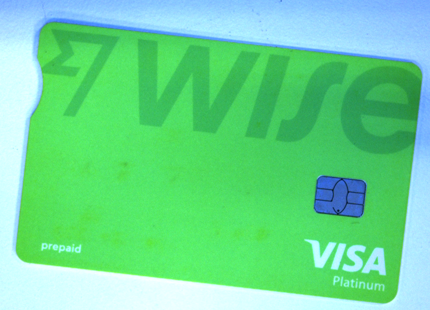

In [117]:
# Load image
filename = 'Lab 1 assets/G1_all.png'

with Image.open(filename) as img:
    img.load()

# Cropping
img = img.crop((200, 120, 1060, 740))

# Resize
img = img.resize((img.width // 2, img.height // 2))

# Gray scale
# img = img.convert('L')

display(img)

# Segmentation

In [118]:
# Dialation and Erosion

def erosion(cycles, image):
    for i in range(cycles):
        image = image.filter(ImageFilter.MinFilter(3))
    return image

def dialation(cycles, image):
    for i in range(cycles):
        image = image.filter(ImageFilter.MaxFilter(3))
    return image

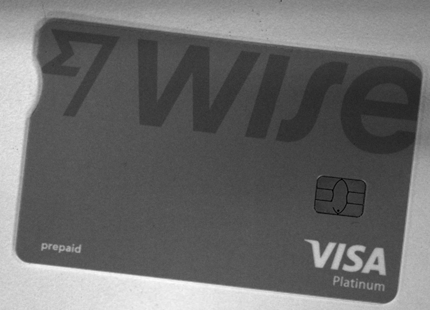

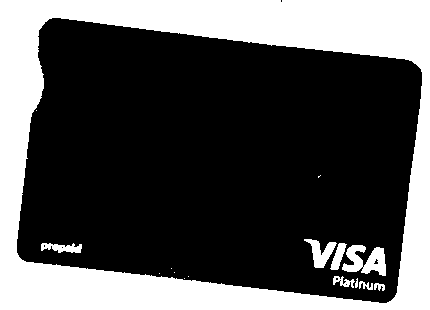

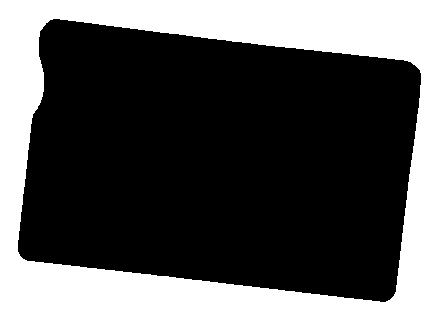

In [128]:
# Thresholding
threshold = 96

# Test intensity of 3 colours
red, green, blue = img.split()
display(red)  # Good with high contrast, but Inverted?
# display(green)  # Mix result
# display(blue)  # Bad

img_threshold = red.point(lambda p: p > threshold and 255)  # change colour channel if needed
display(img_threshold)

# ---------------------------------------------------------------

# Opening 
image_threshold = erosion(6, img_threshold)
image_threshold = dialation(6, image_threshold)

# Remove small noise using dialation
image_threshold = image_threshold.filter(ImageFilter.MaxFilter(3))

display(image_threshold)


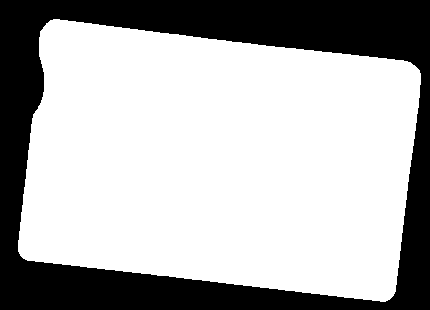

In [129]:
# Invert image for better visualization of object
image_threshold = ImageOps.invert(image_threshold)
display(image_threshold)

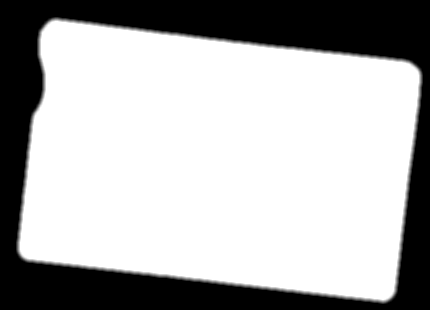

In [130]:
# Convert to gray scale and blur the mask
img_mask = image_threshold.convert('L')
img_mask = img_mask.filter(ImageFilter.BoxBlur(2))
display(img_mask)

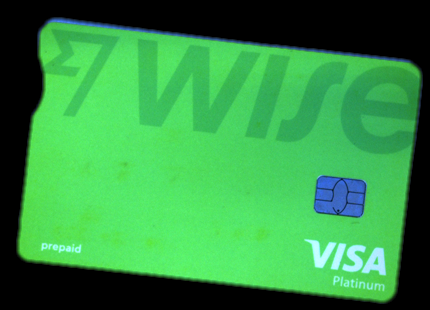

In [125]:
# Extract object
blank = img.point(lambda _: 0)
object_segmented = Image.composite(img, blank, img_mask)
display(object_segmented)